# Sending a neural network to the moon

I absolutely love space, and am obsessed with the moon. Last week [/r/Valphon on Reddit posted](https://www.reddit.com/r/space/comments/l52iym/you_can_send_something_to_the_moon_for_free_im/) that he ordered a "moonbox". Apparently a company called Atrobotic, together with DHL, is offering to send things to the moon for [quite an afforable price](https://www.astrobotic.com/moon-box). He is giving out 10MB of storage space on a first come, first save, limited supply basis. I thought it would be cool to send a neural network to the moon. This is something which, as far as I know, has never been done before!

Then the question is, what neural network to send to the moon? I thought it would be fitting to write a script to train a neural network that can detect moon craters. Even thought the inference will not take place on an SD card, and there is no live data, it still sounds like a useful problem to attempt to solve. Luckily a [team of researchers wrote a paper about this task](https://arxiv.org/abs/1803.02192), and created a dataset. They also created a network to solve the task, and [uploaded their results](https://zenodo.org/record/1133969). Unfortunately this network was over 120 megabytes, over 10 times the allowed size to send for free with this reddit user. I thus decided to download their data and train my own smaller network to send to the moon. 

In this Jupyter Notebook I outline the experiments I did to train a smaller network, and tell what I discovered. 

### Loading the data
To train my neural network I used the [DeepMoon dataset](https://zenodo.org/record/1133969). It consists of two sets of images, where the images are pictures of the surface of the moon and the labels are both "segmentation outputs" where the circles of craters are outlined, and the raw locations of the craters. 

In this case the output is a bit weird in my opinion. The crater circles don't always accurately reflect the position of a crater, and not all craters are "full circles". The neural network has to generalize pretty well to accurately find all craters. Another problem is that not all craters are annotated. This is something the authors of the paper also discovered, and they see it as a benefit that their neural network managed to discover even more craters than were available in the dataset. In any case, loading the data is relatively simple. 

In [1]:
import matplotlib.pyplot as plt
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

from PIL import Image
Image.MAX_IMAGE_PIXELS = None

from skimage.feature import match_template
import albumentations as A
import cv2
import os
import random

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

TENSORBOARD_LOGDIR = 'moonlogs'

def get_images_and_masks(filename):
    with h5py.File(filename, "r") as f:
        # Divide by 255.0 to get floating point images. 
        images = np.array(f['input_images'], dtype=np.float32) / 255.0
        masks = np.array(f['target_masks'], dtype=np.float32)
    return images, masks


## Handling the data
One big issue I found with the data is that the train and test set seem to be from a "different distribution". The authors of the paper took the train, test, and validation set from different parts of the moon. If you take the supplied train and test set the neural network I made had an easier time on the training set than the test set, and the more it fitted on the training set the worse it performed on the test set. I tried to solve this a bit by making my own (completely random) train-test split, and I added a lot of augmentations to the training data. I'm not sure what caused the difference in distribution, but making my own train/test split solved the problem a bit. 

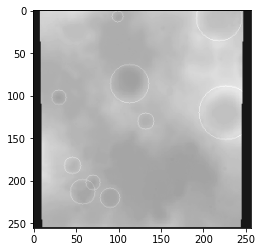

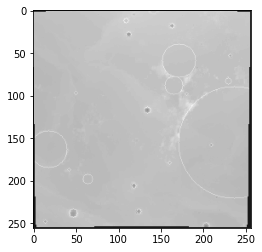

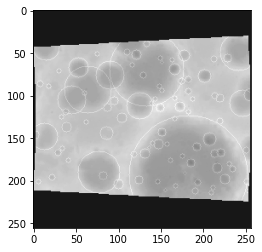

In [2]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5), 
    A.GaussianBlur(p=0.2), 
    A.RandomBrightnessContrast(p=0.4), 
    A.ShiftScaleRotate(border_mode = cv2.BORDER_CONSTANT, p=0.5)
])

class MoonDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, inputs, outputs, batch_size = 16, augment = False):
        self.inputs = inputs
        self.outputs = outputs
        self.batch_size = batch_size
        self.augment = augment
        
        num_samples, w, h = inputs.shape
        self.inputs = self.inputs.reshape((num_samples, w, h, 1))
        self.outputs = self.outputs.reshape((num_samples, w, h, 1))

    def __len__(self):
        """Denotes the number of batches per epoch """
        return len(self.inputs) // self.batch_size

    def __getitem__(self, index):
        batch_in = self.inputs[index*self.batch_size:(index+1)*self.batch_size]
        batch_out = self.outputs[index*self.batch_size:(index+1)*self.batch_size]
        
        if self.augment: 
            for i in range(self.batch_size):
                inp = batch_in[i,...,0]
                out = batch_out[i,...,0]
                
                transformed = transform(image=inp, mask=out)
                inp = transformed['image']
                out = transformed['mask']
                
                batch_in[i,...,0] = inp
                batch_out[i,...,0] = out
        return batch_in, batch_out
    
# Get the images and masks and shuffle them into a new train and test set. 
train_images, train_masks = get_images_and_masks(filename = "train_images.hdf5") 
dev_images, dev_masks = get_images_and_masks(filename = "dev_images.hdf5")
all_images = np.concatenate([train_images, dev_images])
all_masks = np.concatenate([train_masks, dev_masks])

total_images, _, _ = all_images.shape
shuffle = np.arange(total_images)
np.random.shuffle(shuffle)
all_images = all_images[shuffle, ...]
all_masks = all_masks[shuffle, ...]

# Create the generators for the neural network
TRAINING_DATA = int(0.8*total_images)
train_generator = MoonDataGenerator(all_images[:TRAINING_DATA], all_masks[:TRAINING_DATA], batch_size=64, augment=True)
dev_generator = MoonDataGenerator(all_images[TRAINING_DATA:], all_masks[TRAINING_DATA:], batch_size=8)

# Show some example images and their augmentations
for i in range(3): 
    inp, out = train_generator[i]
    plt.imshow(inp[0,..., 0], cmap='gray', alpha=0.9)
    plt.imshow(out[0,...], cmap='gray', alpha=0.1)
    plt.show()
    

## The neural network
The authors of the original paper use an U-net architecture. I wanted to do the same, but am limited to the 10MB for the weights. I thus made a less deep U-net, with a smaller amount of weights. In the end my weights stayed under the 10MB, so they are cleared to go to the moon!

In [3]:
def unet(x, layers, num_output_channels):
    # Downsample
    x = tf.keras.layers.MaxPool2D(padding='same')(x)

    # Convolutions
    convolutions = layers[0]
    for num_neurons in convolutions: 
        x = tf.keras.layers.Conv2D(num_neurons, 3, activation='relu', padding='same')(x)
        
    # Go deeper
    if len(layers) > 1: 
        output_deeper = unet(x, layers[1:], convolutions[0])
        x = tf.keras.layers.Concatenate()([x, output_deeper])
        
    # More convolutions
    for num_neurons in convolutions: 
        x = tf.keras.layers.Conv2D(num_neurons, 3, activation='relu', padding='same')(x)
    
    # Upsample
    x = tf.keras.layers.Conv2DTranspose(num_output_channels, 3, strides=2, padding='same')(x)
    return x

def build_model():
    x_in = tf.keras.layers.Input(shape=(None, None, 1))
    x = x_in

    for i in range(2):
        x = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(x)
    out_p1 = x
    
    x = unet(x, [[64, 64], [128, 128]], 32)
    
    x = tf.keras.layers.Concatenate()([out_p1, x])

    for i in range(2):
        x = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(x)    
    output = tf.keras.layers.Conv2D(1, 3, activation='sigmoid',padding='same')(x)
    
    model = tf.keras.Model(inputs=x_in, outputs=output)
    return model
    
model = build_model()
model.summary()
model.compile(optimizer='adam', loss = tf.keras.losses.BinaryCrossentropy())  
    

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, None, None, 3 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

### Train the network
Training the network is pretty straightforward. As I noticed the network already started overfitting after a few epochs I eventually went for an 'early stopping' method, doing only ten epochs. 

In [4]:
model.fit(train_generator, 
          epochs=10,
          validation_data=dev_generator,
          callbacks=[
                  tf.keras.callbacks.TensorBoard(TENSORBOARD_LOGDIR+'/mymoondata', 
                                                 update_freq='epoch', 
                                                profile_batch=0,),  # log metrics
                ],)
model.save_weights('network.h5')

Epoch 1/10
750/750 [==============================] - 311s 403ms/step - loss: 0.1190 - val_loss: 0.0822
Epoch 2/10
750/750 [==============================] - 303s 403ms/step - loss: 0.0776 - val_loss: 0.0725
Epoch 3/10
750/750 [==============================] - 303s 404ms/step - loss: 0.0688 - val_loss: 0.0686
Epoch 4/10
750/750 [==============================] - 303s 404ms/step - loss: 0.0658 - val_loss: 0.0674
Epoch 5/10
750/750 [==============================] - 303s 404ms/step - loss: 0.0644 - val_loss: 0.0670
Epoch 6/10
750/750 [==============================] - 303s 404ms/step - loss: 0.0636 - val_loss: 0.0677
Epoch 7/10
750/750 [==============================] - 303s 403ms/step - loss: 0.0626 - val_loss: 0.0683
Epoch 8/10
750/750 [==============================] - 302s 403ms/step - loss: 0.0616 - val_loss: 0.0674
Epoch 9/10
750/750 [==============================] - 302s 403ms/step - loss: 0.0610 - val_loss: 0.0685
Epoch 10/10
750/750 [==============================] - 302s 403m

## Show the results
Now that we trained the neural network we should see if it works! Here we plot some results. Overall I'm pretty happy with how well the network generalised from the bad circles as input to actually reasonably segmenting the edges of the craters!

The [GitHub repository](https://github.com/silburt/DeepMoon/) of the authors has a really smart way of getting from this raw predicting to the actual craters of the moon. They match templates of circles in the segmentation image to find the final locations of the craters! It's a smart solution I would have never tried, so I copy-pasted and adjusted their code. 

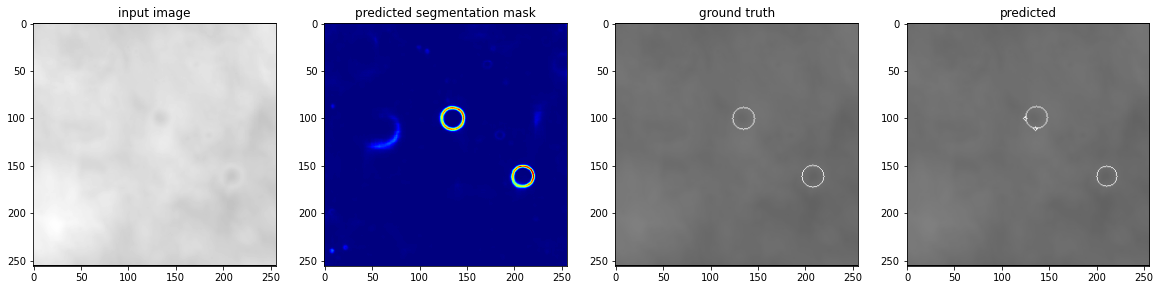

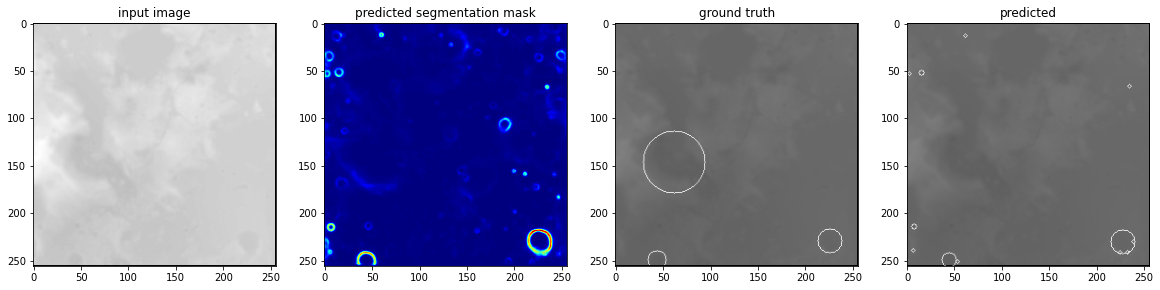

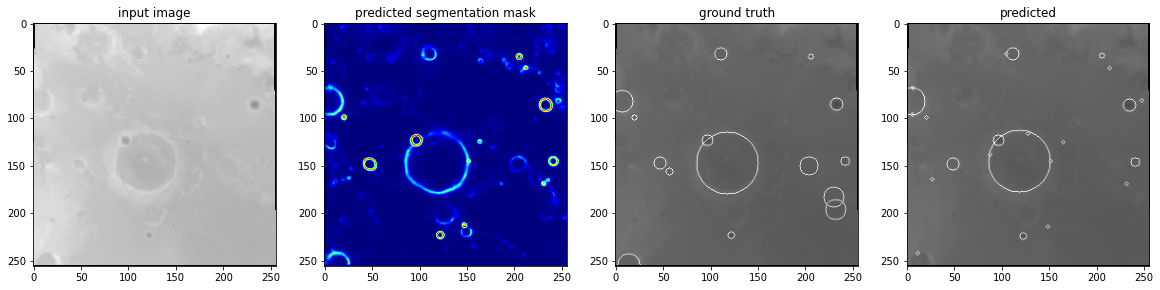

In [9]:
def predict_and_get_prediction_visualisation(image, model, draw_on_image = False):
    """
        Code adapted from: https://github.com/silburt/DeepMoon/blob/master/utils/template_match_target.py
    """
    w, h = image.shape
    reshaped = image.reshape((1,w,h,1))
    # Get the predicted semantic segmentation map 
    predicted_image = model(reshaped)
    predicted_image = predicted_image[0,...,0]
    
    # Settings for the template matching: 
    minrad = 2
    maxrad = 100
    longlat_thresh2 = 1.8
    rad_thresh = 1.0
    template_thresh = 0.5
    target_thresh = 0.1

    # thickness of rings for template match
    thickness_ring = 2

    target = np.copy(predicted_image)

    # threshold the target
    target[target >= target_thresh] = 1
    target[target < target_thresh] = 0

    coords = []     # coordinates extracted from template matching
    corr = []       # correlation coefficient for coordinates set
    for radius in np.arange(minrad, maxrad + 1, 1, dtype=int):
        # template
        size_template = 2 * (radius + thickness_ring + 1)
        template = np.zeros((size_template, size_template))
        cv2.circle(template, (radius + thickness_ring + 1, radius + thickness_ring + 1), radius, 1, thickness_ring)

        # template match - result is nxn array of probabilities
        result = match_template(target, template, pad_input=True)
        index_r = np.where(result > template_thresh)
        coords_r = np.asarray(list(zip(*index_r)))
        corr_r = np.asarray(result[index_r])

        # store x,y,r
        if len(coords_r) > 0:
            for c in coords_r:
                coords.append([c[1], c[0], radius])
            for l in corr_r:
                corr.append(np.abs(l))

    # remove duplicates from template matching at neighboring radii/locations
    coords, corr = np.asarray(coords), np.asarray(corr)
    i, N = 0, len(coords)
    while i < N:
        Long, Lat, Rad = coords.T
        lo, la, radius = coords[i]
        minr = np.minimum(radius, Rad)

        dL = ((Long - lo)**2 + (Lat - la)**2) / minr**2
        dR = abs(Rad - radius) / minr
        index = (dR < rad_thresh) & (dL < longlat_thresh2)
        if len(np.where(index == True)[0]) > 1:
            # replace current coord with max match probability coord in
            # duplicate list
            coords_i = coords[np.where(index == True)]
            corr_i = corr[np.where(index == True)]
            coords[i] = coords_i[corr_i == np.max(corr_i)][0]
            index[i] = False
            coords = coords[np.where(index == False)]
        N, i = len(coords), i + 1

    # Get the raw prediction of only circles:
    if draw_on_image: 
        target = image
    else:
        target = np.zeros(target.shape)
    for x, y, radius in coords: 
        cv2.circle(target, (x,y), radius, (1.0,0,0))
    return predicted_image, target

# For a few inputs, show both the input, segmentation mask, ground truth, and prediction. 
for i in range(3):
    inp, out = dev_generator[i]
    first_image = inp[0,..., 0]
    ground_truth = out[0,...,0]
    
    predicted_segmentation, with_visualisation = predict_and_get_prediction_visualisation(first_image, model)
    
    plt.figure(figsize=(20,20))
    plt.subplot(141)  # 1 row, 2 columns, Plot 1
    plt.imshow(first_image, cmap='gray')
    plt.title('input image')
    
    plt.subplot(142)
    plt.imshow(predicted_segmentation, cmap='jet')
    plt.title('predicted segmentation mask')
    
    plt.subplot(143)
    plt.imshow(first_image, cmap='gray')
    plt.imshow(ground_truth, cmap='gray', alpha=0.5)
    plt.title('ground truth')
    
    plt.subplot(144)
    plt.imshow(first_image, cmap='gray')
    plt.imshow(with_visualisation, cmap='gray', alpha=0.5)
    plt.title('predicted')
    
    plt.show()

    

### Find craters on the whole map
One of available inputs in the DeepMoon dataset is a [very large image of the moon](https://zenodo.org/record/1133969). I ran my neural network, and visualised the result for the whole image. Running it takes quite a bit of time, but the result looks really good!

In [10]:
# Load the large image
im = Image.open("LunarLROLrocKaguya_118mperpix.png")

# Resize the image, because that is closes to the traiing data
w, h = im.size
raw_input_image = np.array(im.resize((w//16, h//16)))
w, h = raw_input_image.shape
raw_input_image = raw_input_image.reshape((1,w, h, 1))

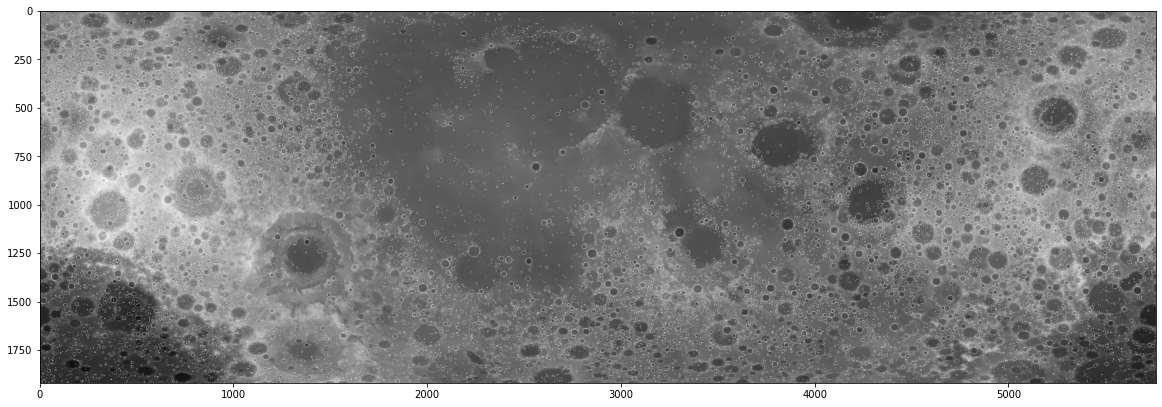

In [11]:

test = raw_input_image.copy() / 255.0
_, h, w, _ = test.shape
image_size = h//2
for y in range(h//image_size):
    for x in range(w//image_size):
        input_image = test[:, y*image_size:(y+1)*image_size, x*image_size:(x+1)*image_size, :]
        first_image = input_image[0,...,0]
        predicted_segmentation, with_visualisation = predict_and_get_prediction_visualisation(first_image, model, draw_on_image=True)
        
plt.figure(figsize=(20,20))
plt.imshow(test[0,...,0], cmap='gray')
plt.show()
plt.imsave('moon.png', test[0,...,0], cmap='gray')

### Conclusion
This was a short but great project to do! I'm really happy with the results, and feel proud to be the first person sending a neural network to the moon! I really hope you enjoyed reading the code and process, and can one day send something to the moon yourself :). 